# Segmentation of Follicles

This practical work aims to investigate image segmentation with a direct application to ovarian follicles. The overall objective is to extract and quantify the granulosa cells and the vascularization of each follicle included in an ewe's ovary.

The image to be processed is a 2D histological image of an ewe's ovary acquired by optical microscopy. The presented image contains one entire follicle (the white region and its neighborhood) and a part of a second one (right-upper corner). The follicle is composed of different parts shown in: antrum, granulosa cells and vascularizations. The theca is the ring region around the antrum where the follicle is vascularized.

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, measure, segmentation, exposure
from skimage.morphology import disk, binary_erosion, binary_dilation, binary_opening, binary_closing
from scipy import ndimage as ndi
import cv2

# Set matplotlib parameters for better visualization
plt.rcParams['figure.figsize'] = (12, 8)

plt.rcParams['image.cmap'] = 'gray'

## 1. Load and Visualize the Image

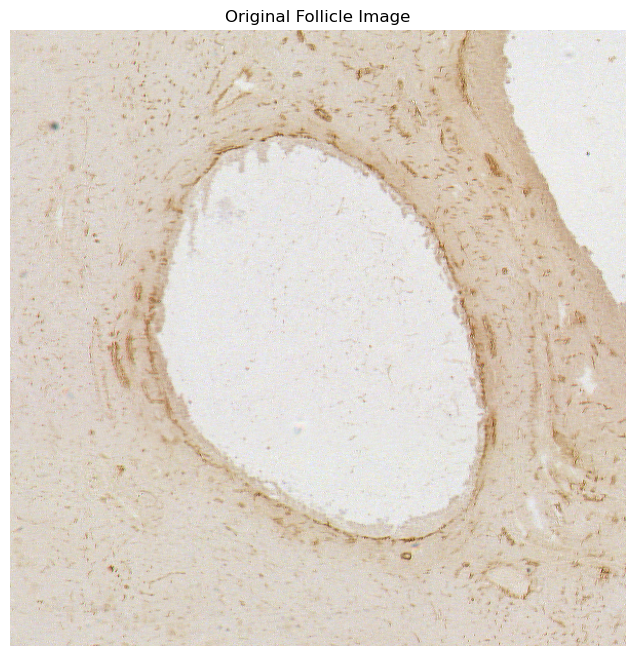

In [6]:
# Load the image
image_path = '../../../data/follicule.bmp'
image = io.imread(image_path)

# Convert to grayscale if the image is RGB
if len(image.shape) == 3:
    gray_image = color.rgb2gray(image)
else:
    gray_image = image / 255.0  # Normalize to [0, 1]
# Display the original image
plt.figure(figsize=(10, 8))
plt.imshow(image, cmap='gray')
plt.title('Original Follicle Image')
plt.axis('off')
plt.show()

# Display the original image in gray
plt.figure(figsize=(10, 8))
plt.imshow(gray_image, cmap='gray')
plt.title('Original Follicle Image in Gray')
plt.axis('off')
plt.show()

# Display histogram to understand intensity distribution
plt.figure(figsize=(10, 4))
plt.hist(gray_image.ravel(), bins=256, range=(0, 1), density=True)
plt.title('Histogram of Pixel Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

## 2. Vascularization

### 2.1 Extract the Antrum of the Follicle

Otsu's threshold value: 0.8137


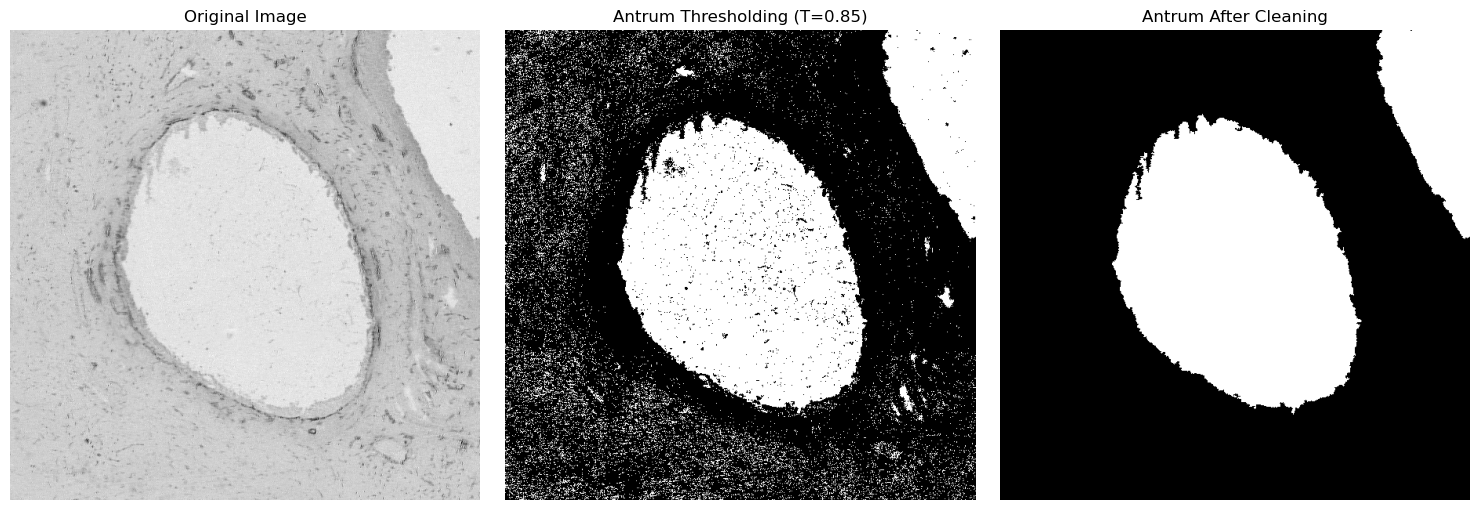

In [7]:
# The antrum is the white region (high intensity) in the center of the follicle
# We can use thresholding to extract it

# Apply Otsu's thresholding to find a good threshold value
thresh_val = filters.threshold_otsu(gray_image)
print(f"Otsu's threshold value: {thresh_val:.4f}")

# We might need to adjust this threshold to better isolate the antrum
# The antrum is the brightest part, so we'll use a higher threshold
antrum_thresh = 0.85  # Adjust this value based on the histogram and visual inspection
antrum_binary = gray_image > antrum_thresh

# Clean up the binary image using morphological operations
# Remove small objects and fill holes
antrum_cleaned = morphology.remove_small_objects(antrum_binary, min_size=1000)
antrum_filled = ndi.binary_fill_holes(antrum_cleaned)

# Display the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(gray_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(antrum_binary, cmap='gray')
axes[1].set_title(f'Antrum Thresholding (T={antrum_thresh:.2f})')
axes[1].axis('off')

axes[2].imshow(antrum_filled, cmap='gray')
axes[2].set_title('Antrum After Cleaning')
axes[2].axis('off')

plt.tight_layout()
plt.show()

### 2.2 Extract the Vascularization (Inside a Ring Around the Antrum)

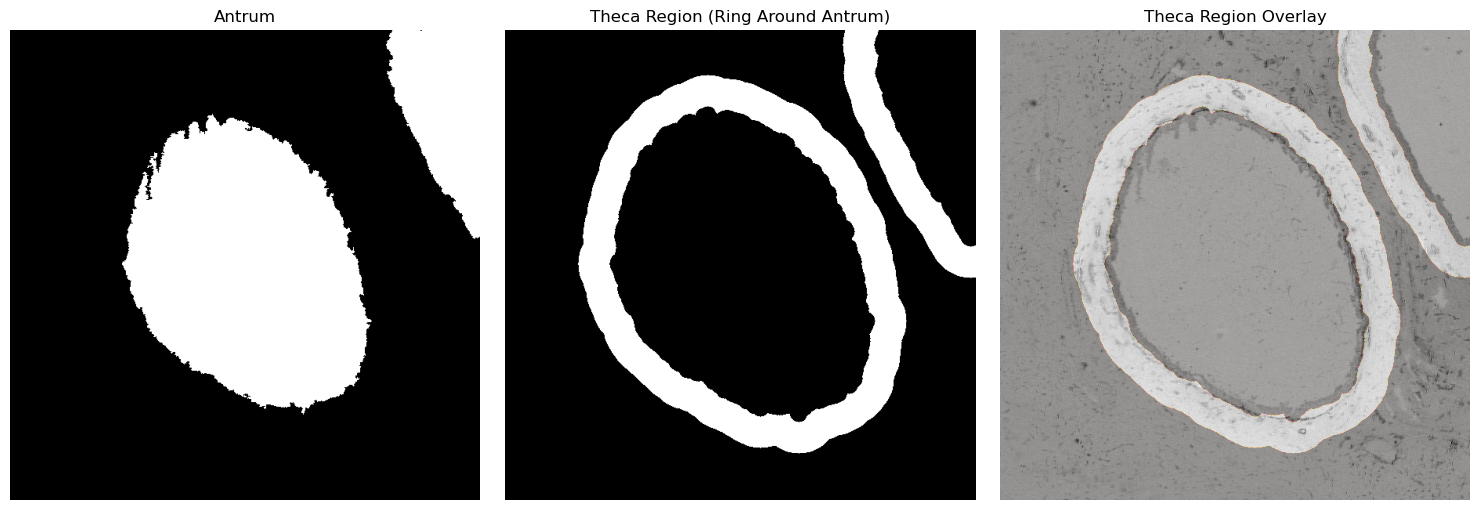

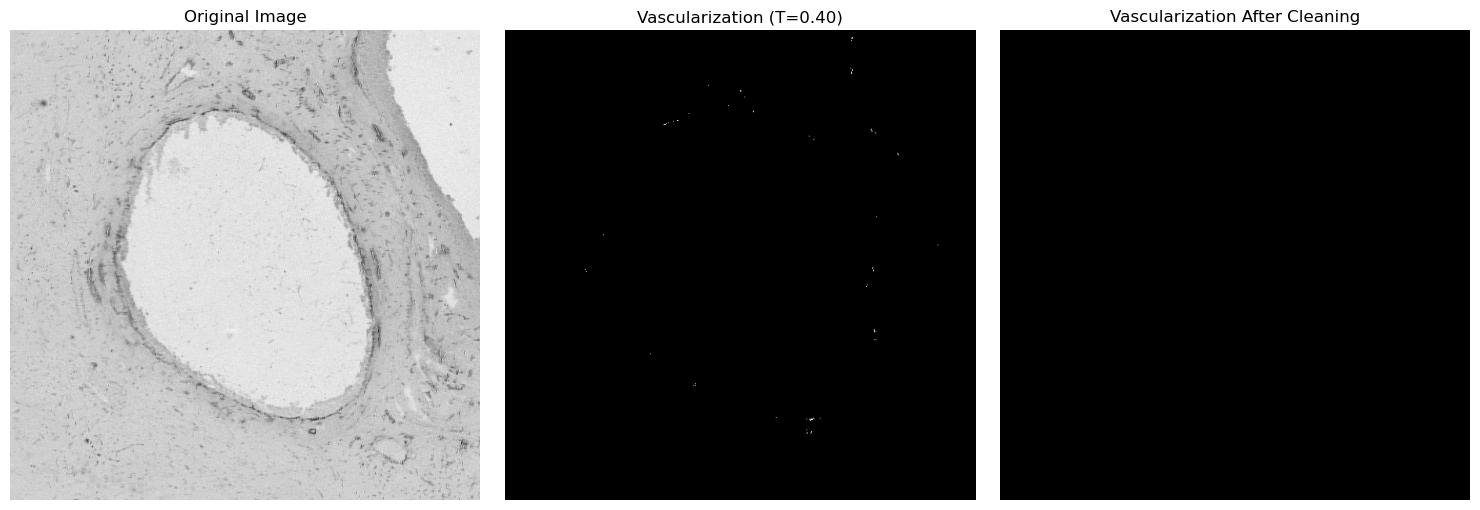

In [8]:
# To extract the vascularization, we need to:
# 1. Create a ring around the antrum (theca region)
# 2. Identify the dark spots within this ring (vascularization)

# Create a dilated version of the antrum to define the outer boundary of the theca
# The size of the structuring element determines the thickness of the ring
outer_se = disk(50)  # Adjust this value based on the image
antrum_dilated = binary_dilation(antrum_filled, outer_se)

# Create a slightly dilated version of the antrum to define the inner boundary of the theca
inner_se = disk(10)  # Adjust this value based on the image
antrum_inner_dilated = binary_dilation(antrum_filled, inner_se)

# The theca region is the ring between the inner and outer dilated regions
theca_region = antrum_dilated & ~antrum_inner_dilated

# Display the theca region
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(antrum_filled, cmap='gray')
axes[0].set_title('Antrum')
axes[0].axis('off')

axes[1].imshow(theca_region, cmap='gray')
axes[1].set_title('Theca Region (Ring Around Antrum)')
axes[1].axis('off')

# Overlay the theca region on the original image
overlay = np.zeros_like(gray_image)
overlay[theca_region] = 1
axes[2].imshow(gray_image, cmap='gray')
axes[2].imshow(overlay, alpha=0.3, cmap='hot')
axes[2].set_title('Theca Region Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Now, extract the vascularization within the theca region
# Vascularization appears as dark spots (low intensity)
# We'll use a threshold to identify these dark regions
vascular_thresh = 0.4  # Adjust this value based on the histogram and visual inspection
vascular_binary = gray_image < vascular_thresh

# Restrict to the theca region
vascularization = vascular_binary & theca_region

# Clean up using morphological operations
vascularization_cleaned = morphology.remove_small_objects(vascularization, min_size=50)

# Display the vascularization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(gray_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(vascularization, cmap='gray')
axes[1].set_title(f'Vascularization (T={vascular_thresh:.2f})')
axes[1].axis('off')

axes[2].imshow(vascularization_cleaned, cmap='gray')
axes[2].set_title('Vascularization After Cleaning')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Overlay the vascularization on the original image
plt.figure(figsize=(10, 8))
plt.imshow(gray_image, cmap='gray')
overlay = np.zeros_like(gray_image)
overlay[vascularization_cleaned] = 1
plt.imshow(overlay, alpha=0.5, cmap='hot')
plt.title('Vascularization Overlay on Original Image')
plt.axis('off')
plt.show()

## 3. Granulosa Cells

Granulosa cells appear as a gray region surrounding the antrum. We'll use a combination of thresholding and morphological operations to extract them.

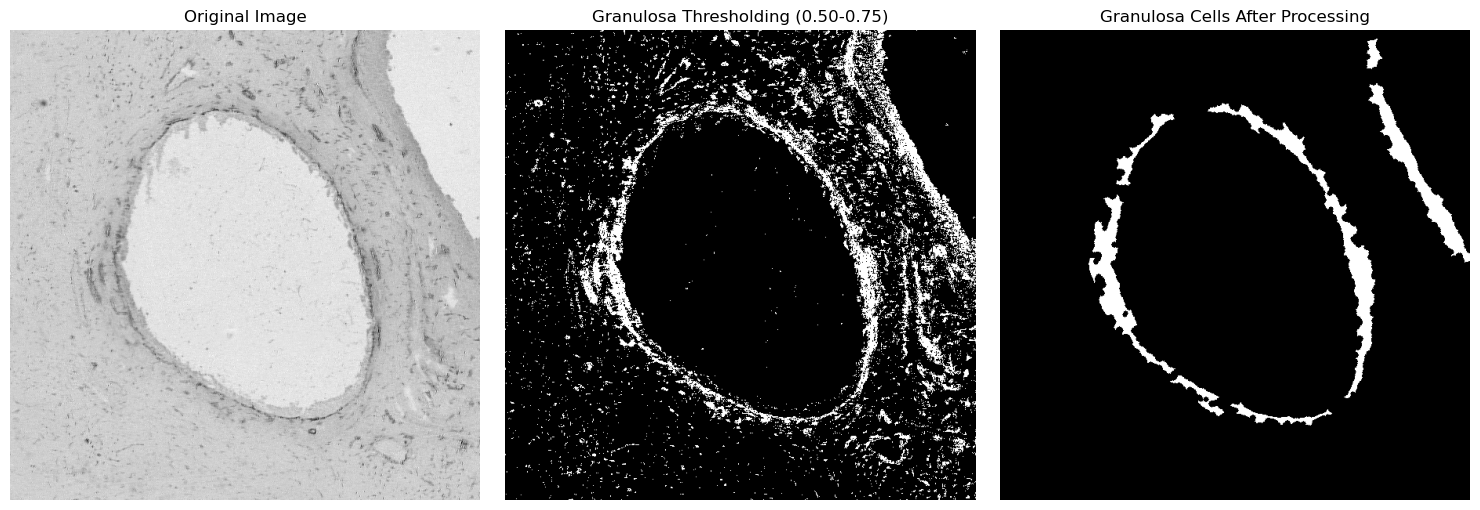

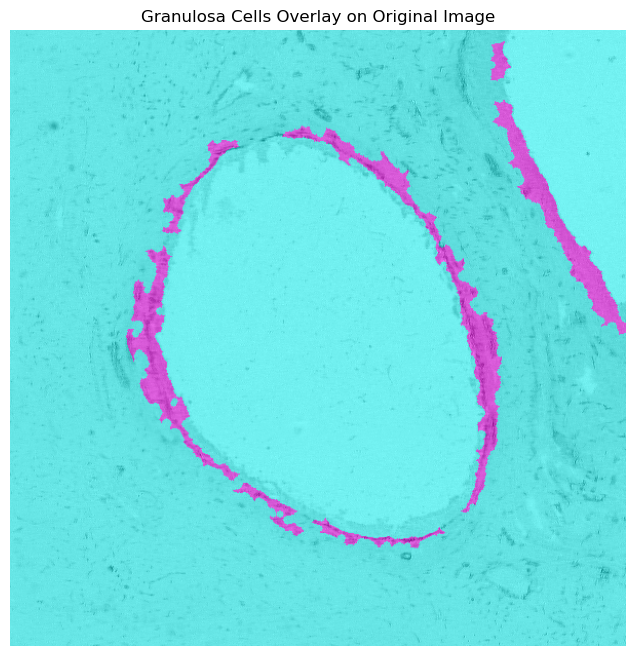

In [9]:
# The granulosa cells are in the medium intensity range
# We'll use a range of thresholds to isolate them
granulosa_lower = 0.5  # Adjust based on histogram
granulosa_upper = 0.75  # Adjust based on histogram

# Create a binary mask for the granulosa cells
granulosa_binary = (gray_image >= granulosa_lower) & (gray_image <= granulosa_upper)

# We need to restrict this to the region around the antrum
# Create a dilated version of the antrum to define the region of interest
granulosa_se = disk(30)  # Adjust this value based on the image
antrum_granulosa_dilated = binary_dilation(antrum_filled, granulosa_se)

# The granulosa cells are in the region around the antrum but not in the antrum itself
granulosa_region = antrum_granulosa_dilated & ~antrum_filled

# Restrict the granulosa cells to this region
granulosa_cells = granulosa_binary & granulosa_region

# Clean up using morphological operations
granulosa_cleaned = morphology.remove_small_objects(granulosa_cells, min_size=100)
granulosa_closed = binary_closing(granulosa_cleaned, disk(3))

# Display the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(gray_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(granulosa_binary, cmap='gray')
axes[1].set_title(f'Granulosa Thresholding ({granulosa_lower:.2f}-{granulosa_upper:.2f})')
axes[1].axis('off')

axes[2].imshow(granulosa_closed, cmap='gray')
axes[2].set_title('Granulosa Cells After Processing')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Overlay the granulosa cells on the original image
plt.figure(figsize=(10, 8))
plt.imshow(gray_image, cmap='gray')
overlay = np.zeros_like(gray_image)
overlay[granulosa_closed] = 1
plt.imshow(overlay, alpha=0.5, cmap='cool')
plt.title('Granulosa Cells Overlay on Original Image')
plt.axis('off')
plt.show()

## 4. Quantification

Now we'll provide some geometrical measurements of the different entities of the follicle (antrum, vascularization, granulosa cells).

In [10]:
# Function to calculate and display measurements
def calculate_measurements(binary_image, name):
    # Label the binary image
    labeled_image, num_features = ndi.label(binary_image)
    
    # Calculate properties
    props = measure.regionprops(labeled_image)
    
    # Total area
    total_area = np.sum(binary_image)
    
    # Calculate perimeter
    perimeter = 0
    for prop in props:
        perimeter += prop.perimeter
    
    # Calculate circularity for the largest region
    if props:
        largest_prop = max(props, key=lambda p: p.area)
        circularity = 4 * np.pi * largest_prop.area / (largest_prop.perimeter ** 2) if largest_prop.perimeter > 0 else 0
    else:
        circularity = 0
    
    # Print results
    print(f"Measurements for {name}:")
    print(f"  - Number of regions: {num_features}")
    print(f"  - Total area (pixels): {total_area}")
    if props:
        print(f"  - Total perimeter (pixels): {perimeter:.2f}")
        print(f"  - Circularity of largest region: {circularity:.4f}")
        print(f"  - Centroid of largest region: ({largest_prop.centroid[1]:.2f}, {largest_prop.centroid[0]:.2f})")
        print(f"  - Major axis length of largest region: {largest_prop.major_axis_length:.2f}")
        print(f"  - Minor axis length of largest region: {largest_prop.minor_axis_length:.2f}")
        print(f"  - Orientation of largest region (degrees): {np.degrees(largest_prop.orientation):.2f}")
    print()
    
    return props

# Calculate measurements for each entity
antrum_props = calculate_measurements(antrum_filled, "Antrum")
vascularization_props = calculate_measurements(vascularization_cleaned, "Vascularization")
granulosa_props = calculate_measurements(granulosa_closed, "Granulosa Cells")

# Calculate the ratio of vascularization to theca area
theca_area = np.sum(theca_region)
vascularization_area = np.sum(vascularization_cleaned)
vascularization_ratio = vascularization_area / theca_area if theca_area > 0 else 0

print(f"Theca region area (pixels): {theca_area}")
print(f"Vascularization to theca ratio: {vascularization_ratio:.4f} ({vascularization_ratio*100:.2f}%)")

# Calculate the ratio of granulosa cells to the total follicle area
follicle_area = np.sum(antrum_granulosa_dilated)
granulosa_area = np.sum(granulosa_closed)
granulosa_ratio = granulosa_area / follicle_area if follicle_area > 0 else 0

print(f"Total follicle area (pixels): {follicle_area}")
print(f"Granulosa to follicle ratio: {granulosa_ratio:.4f} ({granulosa_ratio*100:.2f}%)")

Measurements for Antrum:
  - Number of regions: 2
  - Total area (pixels): 105204
  - Total perimeter (pixels): 2560.76
  - Circularity of largest region: 0.3287
  - Centroid of largest region: (303.18, 302.22)
  - Major axis length of largest region: 386.30
  - Minor axis length of largest region: 280.29
  - Orientation of largest region (degrees): 28.19

Measurements for Vascularization:
  - Number of regions: 0
  - Total area (pixels): 0

Measurements for Granulosa Cells:
  - Number of regions: 7
  - Total area (pixels): 18293
  - Total perimeter (pixels): 3895.33
  - Circularity of largest region: 0.0472
  - Centroid of largest region: (420.32, 259.78)
  - Major axis length of largest region: 461.68
  - Minor axis length of largest region: 95.02
  - Orientation of largest region (degrees): 26.13

Theca region area (pixels): 65907
Vascularization to theca ratio: 0.0000 (0.00%)
Total follicle area (pixels): 153035
Granulosa to follicle ratio: 0.1195 (11.95%)


## 5. Visualization of All Segmented Parts

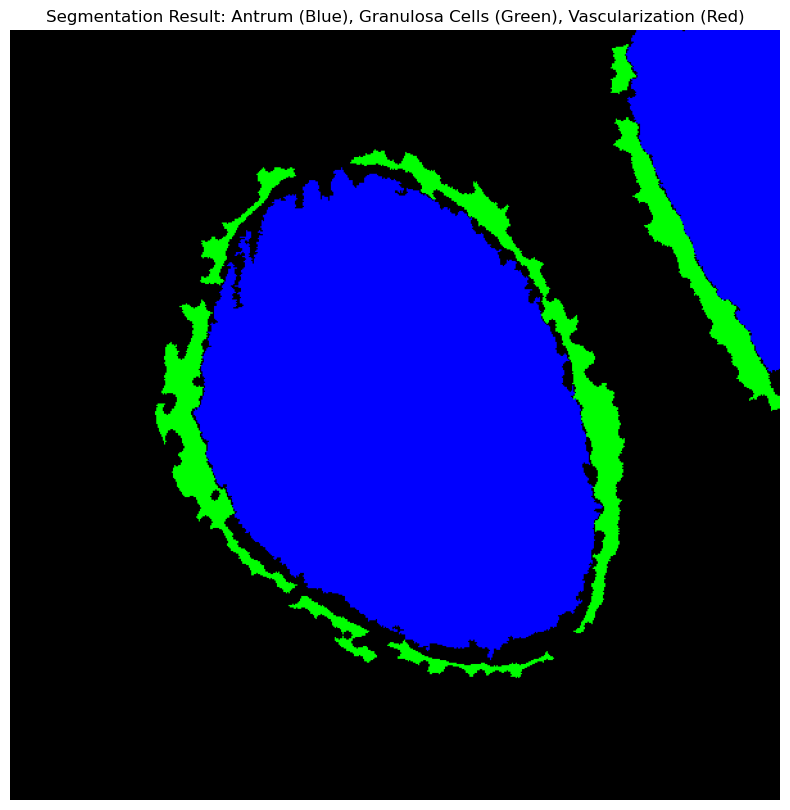

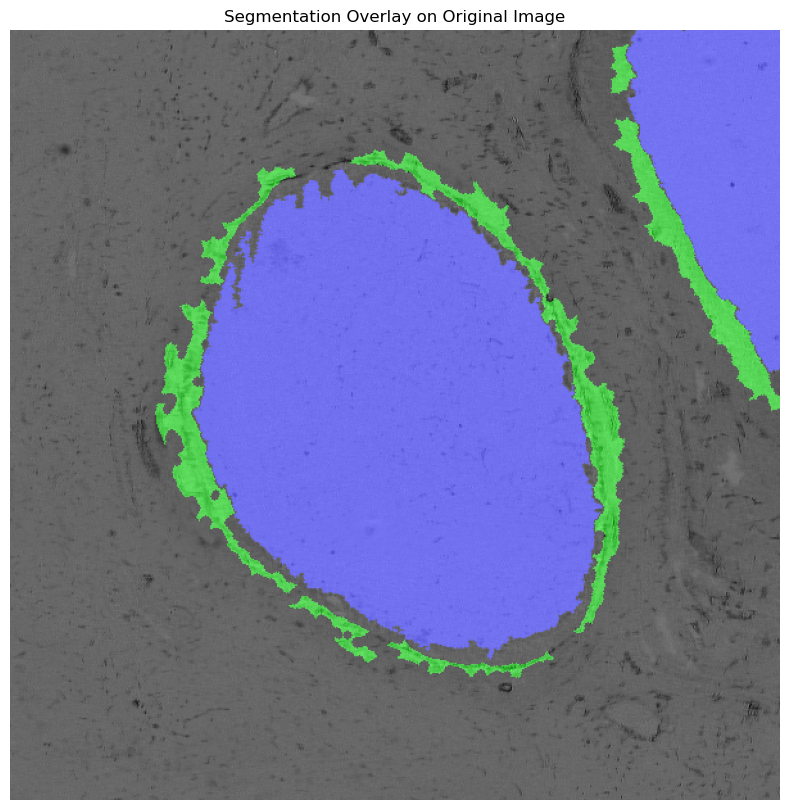

In [11]:
# Create a color-coded image to visualize all parts
segmentation_result = np.zeros((gray_image.shape[0], gray_image.shape[1], 3))

# Antrum - Blue
segmentation_result[antrum_filled, 2] = 1.0

# Granulosa cells - Green
segmentation_result[granulosa_closed, 1] = 1.0

# Vascularization - Red
segmentation_result[vascularization_cleaned, 0] = 1.0

# Display the segmentation result
plt.figure(figsize=(12, 10))
plt.imshow(segmentation_result)
plt.title('Segmentation Result: Antrum (Blue), Granulosa Cells (Green), Vascularization (Red)')
plt.axis('off')
plt.show()

# Create an overlay on the original image
plt.figure(figsize=(12, 10))
plt.imshow(gray_image, cmap='gray')
plt.imshow(segmentation_result, alpha=0.5)
plt.title('Segmentation Overlay on Original Image')
plt.axis('off')
plt.show()

## 6. Conclusion

In this practical work, we have successfully segmented the different parts of an ovarian follicle:

1. **Antrum**: The central cavity of the follicle, extracted using thresholding and morphological operations.
2. **Vascularization**: The blood vessels in the theca region, identified as dark spots within a ring around the antrum.
3. **Granulosa Cells**: The cells surrounding the antrum, extracted using a combination of thresholding and morphological operations.

We have also provided quantitative measurements for each of these entities, including area, perimeter, and shape descriptors. These measurements can be used to assess the development and health of the follicle.

The segmentation approach used in this work combines classical image processing techniques such as thresholding and mathematical morphology. These techniques are particularly well-suited for this application due to the distinct intensity characteristics of the different parts of the follicle.